In [1]:
%%sh
rm -r sample_data
pip install --upgrade pandas
pip install --upgrade geopandas
pip install --upgrade fiona shapely pyproj rtree pygeos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

import os
import ftplib

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from multiprocessing import Pool

from IPython.display import clear_output
from IPython.display import display

import time
from numba import jit

import warnings
warnings.filterwarnings('ignore', message = '.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message = '.*Geometry is in a geographic CRS.*')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pasta_out = 'drive/MyDrive/Aprendizado_Maquina/Projeto_IBGE/dados_tratados'

# Baixa Dados do Censo 2010

In [ ]:
#Arquivos baixados do FTP do IBGE
#https://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/

ftp = ftplib.FTP('ftp.ibge.gov.br')
ftp.login()
ftp.cwd('Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios')

os.system('mkdir resultados')
arquivos = ftp.nlst()
for arq in arquivos:
    filename = f'resultados/{arq}'
    with open(filename, 'wb') as fobj:
        ftp.retrbinary('RETR %s' % arq, fobj.write)

ftp.quit()

'221 Goodbye.'

In [ ]:
#Arquivos baixados do GEOFTP do IBGE
#https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/

ftp = ftplib.FTP('geoftp.ibge.gov.br')
ftp.login()
diretorio = 'organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp'
ftp.cwd(diretorio)

os.system('mkdir malha')
pastas = ftp.nlst()

ftp.quit()

'221 Goodbye.'

In [ ]:
for pasta in pastas:
    ftp = ftplib.FTP('geoftp.ibge.gov.br')
    ftp.login()
    diretorio = 'organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp'
    ftp.cwd(f'{diretorio}/{pasta}')

    arquivos = ftp.nlst()
    arquivos = [f for f in arquivos if f.find('.zip') != -1 and f.find('setores_censitarios') != -1]
    if(len(arquivos) > 0):
        for arq in arquivos:
            filename = f'malha/{arq}'
            with open(filename, 'wb') as fobj:
                ftp.retrbinary('RETR %s' % arq, fobj.write)

    ftp.quit()

# Trata Dados do Censo 2010

In [ ]:
def carrega_dados_malha(arq):
    dict_types = {'ID': str,
                  'CD_GEOCODI': str,
                  'CD_GEOCODB': str,
                  'CD_GEOCODS': str,
                  'CD_GEOCODD': str,
                  'CD_GEOCODM': str}
    gdf = gpd.read_file(arq, dtype = dict_types)
    cols = ['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS', 'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 
            'CD_GEOCODM', 'NM_MUNICIP', 'NM_MICRO', 'NM_MESO', 'geometry']
    return gdf[cols]

gdf_malha = pd.concat([carrega_dados_malha(f'malha/{arq}') for arq in os.listdir('malha')])

In [ ]:
gdf_malha.to_parquet(f'{pasta_out}/malha_setores_censitarios_2010.parquet')

In [ ]:
os.system(f'unzip resultados/Documentacao_Agregado_dos_Setores_20180416.zip')

0

In [ ]:
def lista_arquivos():
    arquivos = []
    for root, dirnames, filenames in os.walk('resultados_unzip'):
        for filename in filenames:
            arquivos.append(os.path.join(root, filename))
    return arquivos

def trata_resultados():
    arquivos = lista_arquivos()

    lista_df = []

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Basico') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df[['Cod_setor', 'V005', 'V009']]
    df = df.rename({'Cod_setor': 'CD_GEOCODI',
                    'V005': 'Rendimento_Medio_por_Domicilio',
                    'V009': 'Rendimento_Medio_por_Pessoa'}, axis = 1)
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Domicilio01') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df[['Cod_setor', 'V001']]
    df = df.rename({'Cod_setor': 'CD_GEOCODI',
                    'V001': 'Qtd_Domicilios'}, axis = 1)
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Pessoa03') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df[['Cod_setor', 'V001', 'V002', 'V003', 'V004', 'V005', 'V006']]
    df = df.rename({'Cod_setor': 'CD_GEOCODI',
                    'V001': 'Qtd_Pessoas',
                    'V002': 'Qtd_Pessoas_Brancas',
                    'V003': 'Qtd_Pessoas_Pretas',
                    'V004': 'Qtd_Pessoas_Amarelas',
                    'V005': 'Qtd_Pessoas_Pardas',
                    'V006': 'Qtd_Pessoas_Indigenas'}, axis = 1)
    df['Qtd_Pessoas_Brancas'] = pd.to_numeric(df['Qtd_Pessoas_Brancas'], errors = 'coerce').fillna(0)
    df['Qtd_Pessoas_Pretas'] = pd.to_numeric(df['Qtd_Pessoas_Pretas'], errors = 'coerce').fillna(0)
    df['Qtd_Pessoas_Amarelas'] = pd.to_numeric(df['Qtd_Pessoas_Amarelas'], errors = 'coerce').fillna(0)
    df['Qtd_Pessoas_Pardas'] = pd.to_numeric(df['Qtd_Pessoas_Pardas'], errors = 'coerce').fillna(0)
    df['Qtd_Pessoas_Indigenas'] = pd.to_numeric(df['Qtd_Pessoas_Indigenas'], errors = 'coerce').fillna(0)
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('DomicilioRenda') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df[['Cod_setor', 'V002']]
    df = df.rename({'Cod_setor': 'CD_GEOCODI',
                    'V002': 'Rendimento_Total_10anosmais'}, axis = 1)
    df['Rendimento_Total_10anosmais'] = pd.to_numeric(df['Rendimento_Total_10anosmais'], errors = 'coerce')
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Pessoa01') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df[['Cod_setor', 'V001']]
    df = df.rename({'Cod_setor': 'CD_GEOCODI',
                    'V001': 'Qtd_Alfabetizados_5anosmais'}, axis = 1)
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Pessoa02') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df[['Cod_setor', 'V086', 'V171']]
    df = df.rename({'Cod_setor': 'CD_GEOCODI',
                    'V086': 'Qtd_Homens_Alfabetizados_5anosmais',
                    'V171': 'Qtd_Mulheres_Alfabetizadas_5anosmais'}, axis = 1)
    df['Qtd_Homens_Alfabetizados_5anosmais'] = pd.to_numeric(df['Qtd_Homens_Alfabetizados_5anosmais'], errors = 'coerce').fillna(0)
    df['Qtd_Mulheres_Alfabetizadas_5anosmais'] = pd.to_numeric(df['Qtd_Mulheres_Alfabetizadas_5anosmais'], errors = 'coerce').fillna(0)
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Pessoa13') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df.rename({'Cod_setor': 'CD_GEOCODI'}, axis = 1)
    vetor_idades = np.arange(1, 100)
    vetor_colunas = ['V' + ('000' + str(34+i))[-3:] for i in vetor_idades]
    for v in vetor_colunas:
        df[v] = pd.to_numeric(df[v], errors = 'coerce').fillna(0)
    df['V134'] = pd.to_numeric(df['V134'], errors = 'coerce').fillna(0) #Pessoas com 100 anos ou mais
    df['Qtd_Jovens'] = df[vetor_colunas[:18]].sum(axis = 1)
    df['Qtd_PEA'] = df[vetor_colunas[18:59]].sum(axis = 1)
    df['Qtd_Idosos'] = df[vetor_colunas[59:]].sum(axis = 1)
    df['Qtd_Pessoas_1a99anos'] = df[vetor_colunas].sum(axis = 1)
    df['Qtd_Pessoas_5anosmais'] = df[vetor_colunas[4:]].sum(axis = 1) + df['V134']
    df['Qtd_Pessoas_10anosmais'] = df[vetor_colunas[9:]].sum(axis = 1) + df['V134']
    df['Idade_Media_Numerador'] = np.sum([i*df[vetor_colunas[i-1]] for i in vetor_idades], axis = 0)
    df = df[['CD_GEOCODI', 'Qtd_Jovens', 'Qtd_PEA', 'Qtd_Idosos', 'Qtd_Pessoas_1a99anos', 
             'Qtd_Pessoas_5anosmais', 'Qtd_Pessoas_10anosmais',
             'Idade_Media_Numerador']]
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Pessoa11') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df.rename({'Cod_setor': 'CD_GEOCODI'}, axis = 1)
    vetor_idades = np.arange(1, 100)
    vetor_colunas = ['V' + ('000' + str(34+i))[-3:] for i in vetor_idades]
    for v in vetor_colunas:
        df[v] = pd.to_numeric(df[v], errors = 'coerce').fillna(0)
    df['V134'] = pd.to_numeric(df['V134'], errors = 'coerce').fillna(0) #Pessoas com 100 anos ou mais
    df['Qtd_Homens_5anosmais'] = df[vetor_colunas[4:]].sum(axis = 1) + df['V134']
    df['Qtd_Homens'] = pd.to_numeric(df['V001'], errors = 'coerce').fillna(0)
    df = df[['CD_GEOCODI', 'Qtd_Homens_5anosmais', 'Qtd_Homens']]
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    arq = [f for f in arquivos if f.find('.csv') != -1 and f.find('Pessoa12') != -1][0]
    df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'latin-1', low_memory = False)
    if 'Cod_setor' not in df.columns:
        df = pd.read_csv(arq, sep = ';', decimal = ',', dtype = {'Cod_setor': str}, encoding = 'utf-8', low_memory = False)
    df = df.rename({'Cod_setor': 'CD_GEOCODI'}, axis = 1)
    vetor_idades = np.arange(1, 100)
    vetor_colunas = ['V' + ('000' + str(34+i))[-3:] for i in vetor_idades]
    for v in vetor_colunas:
        df[v] = pd.to_numeric(df[v], errors = 'coerce').fillna(0)
    df['V134'] = pd.to_numeric(df['V134'], errors = 'coerce').fillna(0) #Pessoas com 100 anos ou mais
    df['Qtd_Mulheres_5anosmais'] = df[vetor_colunas[4:]].sum(axis = 1) + df['V134']
    df['Qtd_Mulheres'] = pd.to_numeric(df['V001'], errors = 'coerce').fillna(0)
    df = df[['CD_GEOCODI', 'Qtd_Mulheres_5anosmais', 'Qtd_Mulheres']]
    df = df.set_index('CD_GEOCODI')
    lista_df.append(df)

    ##################################################################

    df = pd.concat(lista_df, axis = 1).reset_index()
    df['Pessoas_por_Domicilio'] = df['Qtd_Pessoas']/df['Qtd_Domicilios']

    #Calcula Percentual de Homens e Mulheres
    df['Perc_Homens'] = df['Qtd_Homens']*100/df['Qtd_Pessoas']
    df['Perc_Mulheres'] = df['Qtd_Mulheres']*100/df['Qtd_Pessoas']

    #Calcular Percentual por Etnia
    df['Perc_Brancos'] = df['Qtd_Pessoas_Brancas']*100/df['Qtd_Pessoas']
    df['Perc_Negros'] = df['Qtd_Pessoas_Pretas']*100/df['Qtd_Pessoas']
    df['Perc_Amarelos'] = df['Qtd_Pessoas_Amarelas']*100/df['Qtd_Pessoas']
    df['Perc_Pardos'] = df['Qtd_Pessoas_Pardas']*100/df['Qtd_Pessoas']
    df['Perc_Indigenas'] = df['Qtd_Pessoas_Indigenas']*100/df['Qtd_Pessoas']

    #Calcula o Percentual de Alfabetização
    frac_5anosmais = (df['Qtd_Pessoas_5anosmais']/df['Qtd_Pessoas']).dropna().mean()
    df['Perc_Alfabetizacao'] = df['Qtd_Alfabetizados_5anosmais']*100/df['Qtd_Pessoas_5anosmais']
    mask = df['Perc_Alfabetizacao'].isna()
    df.loc[mask, 'Perc_Alfabetizacao'] = df.loc[mask, 'Qtd_Alfabetizados_5anosmais']*100/(df['Qtd_Pessoas']*frac_5anosmais)

    #Calcula o Percentual de Alfabetização dos Homens
    frac_homens_5anosmais = (df['Qtd_Homens_5anosmais']/df['Qtd_Pessoas']).dropna().mean()
    df['Perc_Alfabetizacao_Homens'] = df['Qtd_Homens_Alfabetizados_5anosmais']*100/df['Qtd_Homens_5anosmais']
    mask = df['Perc_Alfabetizacao_Homens'].isna()
    df.loc[mask, 'Perc_Alfabetizacao_Homens'] = df.loc[mask, 'Qtd_Homens_Alfabetizados_5anosmais']*100/(df['Qtd_Pessoas']*frac_homens_5anosmais)

    #Calcula o Percentual de Alfabetização das Mulheres
    frac_mulheres_5anosmais = (df['Qtd_Mulheres_5anosmais']/df['Qtd_Pessoas']).dropna().mean()
    df['Perc_Alfabetizacao_Mulheres'] = df['Qtd_Mulheres_Alfabetizadas_5anosmais']*100/df['Qtd_Mulheres_5anosmais']
    mask = df['Perc_Alfabetizacao_Mulheres'].isna()
    df.loc[mask, 'Perc_Alfabetizacao_Mulheres'] = df.loc[mask, 'Qtd_Mulheres_Alfabetizadas_5anosmais']*100/(df['Qtd_Pessoas']*frac_mulheres_5anosmais)

    #Calcula os Percentuais de Jovens, PEA, Idosos e a Idade Média
    frac_1a99 = (df['Qtd_Pessoas_1a99anos']/df['Qtd_Pessoas']).dropna().mean()
    df['Perc_Jovens'] = df['Qtd_Jovens']*100/df['Qtd_Pessoas_1a99anos']
    mask = df['Perc_Jovens'].isna()
    df.loc[mask, 'Perc_Jovens'] = df.loc[mask, 'Qtd_Jovens']*100/(df['Qtd_Pessoas']*frac_1a99)
    df['Perc_PEA'] = df['Qtd_PEA']*100/df['Qtd_Pessoas_1a99anos']
    mask = df['Perc_PEA'].isna()
    df.loc[mask, 'Perc_PEA'] = df.loc[mask, 'Qtd_PEA']*100/(df['Qtd_Pessoas']*frac_1a99)
    df['Perc_Idosos'] = df['Qtd_Idosos']*100/df['Qtd_Pessoas_1a99anos']
    mask = df['Perc_Idosos'].isna()
    df.loc[mask, 'Perc_Idosos'] = df.loc[mask, 'Qtd_Idosos']*100/(df['Qtd_Pessoas']*frac_1a99)
    df['Idade_Media'] = df['Idade_Media_Numerador']/df['Qtd_Pessoas_1a99anos']
    mask = df['Idade_Media'].isna()
    df.loc[mask, 'Idade_Media'] = df.loc[mask, 'Idade_Media_Numerador']/(df['Qtd_Pessoas']*frac_1a99)

    #Corrige as Colunas de Rendimento Medio por Domicilio onde estiver nulo
    frac_10anosmais = (df['Qtd_Pessoas_10anosmais']/df['Qtd_Pessoas']).dropna().mean()
    mask = df['Rendimento_Medio_por_Domicilio'].isna() & (~df['Rendimento_Medio_por_Pessoa'].isna())
    df.loc[mask, 'Rendimento_Medio_por_Domicilio'] = df.loc[mask, 'Rendimento_Medio_por_Pessoa']*df.loc[mask, 'Qtd_Pessoas_10anosmais']/df.loc[mask, 'Qtd_Domicilios']
    mask = df['Rendimento_Medio_por_Domicilio'].isna() & (~df['Rendimento_Total_10anosmais'].isna())
    df.loc[mask, 'Rendimento_Medio_por_Domicilio'] = df.loc[mask, 'Rendimento_Total_10anosmais']/df.loc[mask, 'Qtd_Domicilios']
    mask = df['Rendimento_Medio_por_Domicilio'].isna() & (~df['Rendimento_Medio_por_Pessoa'].isna()) & (df['Qtd_Pessoas_10anosmais'] == 0)
    df.loc[mask, 'Rendimento_Medio_por_Domicilio'] = df.loc[mask, 'Rendimento_Medio_por_Pessoa']*(df.loc[mask, 'Qtd_Pessoas']*frac_10anosmais)/df.loc[mask, 'Qtd_Domicilios']

    #Corrige as Colunas de Rendimento Medio por Pessoa onde estiver nulo
    mask = df['Rendimento_Medio_por_Pessoa'].isna() & (~df['Rendimento_Medio_por_Domicilio'].isna())
    df.loc[mask, 'Rendimento_Medio_por_Pessoa'] = df.loc[mask, 'Rendimento_Medio_por_Domicilio']*df.loc[mask, 'Qtd_Domicilios']/df.loc[mask, 'Qtd_Pessoas_10anosmais']
    mask = df['Rendimento_Medio_por_Pessoa'].isna() & (~df['Rendimento_Medio_por_Domicilio'].isna()) & (df['Qtd_Pessoas_10anosmais'] == 0)
    df.loc[mask, 'Rendimento_Medio_por_Pessoa'] = df.loc[mask, 'Rendimento_Medio_por_Domicilio']*df.loc[mask, 'Qtd_Domicilios']/(df.loc[mask, 'Qtd_Pessoas']*frac_10anosmais)
    mask = df['Rendimento_Medio_por_Pessoa'].isna() & (~df['Rendimento_Total_10anosmais'].isna())
    df.loc[mask, 'Rendimento_Medio_por_Pessoa'] = df.loc[mask, 'Rendimento_Total_10anosmais']/df.loc[mask, 'Qtd_Pessoas_10anosmais']
    mask = df['Rendimento_Medio_por_Pessoa'].isna() & (~df['Rendimento_Total_10anosmais'].isna()) & (df['Qtd_Pessoas_10anosmais'] == 0)
    df.loc[mask, 'Rendimento_Medio_por_Pessoa'] = df.loc[mask, 'Rendimento_Total_10anosmais']/(df.loc[mask, 'Qtd_Pessoas']*frac_10anosmais)

    df = df.drop(['Qtd_Homens', 'Qtd_Mulheres',
                  'Qtd_Pessoas_Brancas', 'Qtd_Pessoas_Pretas', 'Qtd_Pessoas_Amarelas', 'Qtd_Pessoas_Pardas', 'Qtd_Pessoas_Indigenas',
                  'Qtd_Alfabetizados_5anosmais', 'Qtd_Pessoas_5anosmais',
                  'Qtd_Homens_Alfabetizados_5anosmais', 'Qtd_Homens_5anosmais',
                  'Qtd_Mulheres_Alfabetizadas_5anosmais', 'Qtd_Mulheres_5anosmais',
                  'Qtd_Jovens', 'Qtd_PEA', 'Qtd_Idosos', 'Idade_Media_Numerador', 'Qtd_Pessoas_1a99anos', 
                  'Rendimento_Total_10anosmais', 'Qtd_Pessoas_10anosmais'
                  ], axis = 1)
    return df

In [ ]:
lista_df = []
for arq in [f for f in os.listdir('resultados') if f.find('.zip') != -1 and f.find('Documentacao') == -1]:
    print(arq)
    os.system('mkdir resultados_unzip')
    os.system(f'unzip resultados/{arq} -d resultados_unzip')
    lista_df.append(trata_resultados())
    os.system('rm -r resultados_unzip')

RS_20171016.zip
AM_20171016.zip
SP_Exceto_a_Capital_20190207.zip
PE_20200219.zip
SC_20171016.zip
CE_20171016.zip
RJ_20171016.zip
BA_20171016.zip
SE_20171016.zip
PR_20171016.zip
TO_20171016.zip
PA_20171016.zip
PI_20171016.zip
GO_20171016.zip
DF_20171016.zip
AL_20171016.zip
RO_20171016.zip
SP_Capital_20190823.zip
PB_20171016.zip
RN_20171016.zip
ES_20171016.zip
MS_20171016.zip
RR_20171016.zip
AP_20171016.zip
MT_20171016.zip
MG_20171016.zip
MA_20171016.zip
AC_20171016.zip


In [ ]:
df_info = pd.concat(lista_df).reset_index(drop = True).set_index('CD_GEOCODI')
df_info = df_info.sort_index().reset_index()

In [ ]:
df_info.isna().sum()

CD_GEOCODI                        0
Rendimento_Medio_por_Domicilio    0
Rendimento_Medio_por_Pessoa       0
Qtd_Domicilios                    0
Qtd_Pessoas                       0
Pessoas_por_Domicilio             0
Perc_Homens                       0
Perc_Mulheres                     0
Perc_Brancos                      0
Perc_Negros                       0
Perc_Amarelos                     0
Perc_Pardos                       0
Perc_Indigenas                    0
Perc_Alfabetizacao                0
Perc_Alfabetizacao_Homens         0
Perc_Alfabetizacao_Mulheres       0
Perc_Jovens                       0
Perc_PEA                          0
Perc_Idosos                       0
Idade_Media                       0
dtype: int64

In [ ]:
df_info.to_parquet(f'{pasta_out}/informacoes_setores_censitarios_2010.parquet')

# Features de Suavização Radial

In [ ]:
gdf_info = pd.merge(gdf_malha[['CD_GEOCODI', 'geometry']], df_info, how = 'inner', on = 'CD_GEOCODI')

In [ ]:
gdf_esq = gdf_malha[['CD_GEOCODI', 'geometry']].copy()
centroides = gdf_esq['geometry'].centroid

In [ ]:
def join_ponderado_area(gdf_esq, gdf_info):
    gdf_join = gpd.sjoin(gdf_esq, gdf_info, how = 'inner', lsuffix = 'left', rsuffix = 'right').drop('index_right', axis = 1)
    gdf_join = gdf_join.rename({'CD_GEOCODI_left': 'CD_GEOCODI'}, axis = 1)

    gdf_join = pd.merge(gdf_join, gdf_info[['CD_GEOCODI', 'geometry']].rename({'CD_GEOCODI': 'CD_GEOCODI_right', 
                                                                               'geometry': 'geometry_right'}, axis = 1), 
                        how = 'left', on = 'CD_GEOCODI_right').drop('CD_GEOCODI_right', axis = 1)
    
    area_right = gdf_join['geometry_right'].area
    area_intersecao = gdf_join['geometry'].intersection(gdf_join['geometry_right'], align = True).area
    df_join = pd.DataFrame(gdf_join.drop(['geometry', 'geometry_right'], axis = 1))
    df_join['Ponderador_Area'] = area_intersecao/area_right

    return df_join

@jit(nopython = True)
def soma_vetor(vetor):
    return np.sum(vetor)

def groupby_ponderado_area(df_join):

    def f_agg(x):
        d = {}
        vetor_ponderador = x['Ponderador_Area'].values
        d['Qtd_Setores_Raio'] = soma_vetor(vetor_ponderador)

        vetor_domicilios = vetor_ponderador*x['Qtd_Domicilios'].values
        vetor_pessoas = vetor_ponderador*x['Qtd_Pessoas'].values
        d['Qtd_Domicilios'] = soma_vetor(vetor_domicilios)
        d['Qtd_Pessoas'] = soma_vetor(vetor_pessoas)

        cols = ['Pessoas_por_Domicilio', 'Rendimento_Medio_por_Domicilio']
        for c in cols:
            d[c] = soma_vetor(vetor_domicilios*x[c].values)/d['Qtd_Domicilios']

        cols = ['Rendimento_Medio_por_Pessoa', 
                'Perc_Homens', 'Perc_Mulheres', 
                'Perc_Brancos', 'Perc_Negros', 'Perc_Amarelos', 'Perc_Pardos', 'Perc_Indigenas',
                'Perc_Alfabetizacao', 
                'Perc_Alfabetizacao_Homens', 'Perc_Alfabetizacao_Mulheres',
                'Perc_Jovens', 'Perc_PEA', 'Perc_Idosos', 'Idade_Media']
        for c in cols:
            d[c] = soma_vetor(vetor_pessoas*x[c].values)/d['Qtd_Pessoas']

        return pd.Series(d)

    df = df_join[~df_join['Ponderador_Area'].isna()]
    df_agg = df.groupby('CD_GEOCODI').apply(lambda x: f_agg(x))
    return df_agg

In [ ]:
def processamento_pool(tupla):
    gdf_esq, gdf_info, dh = tupla

    N = max(int(gdf_esq.shape[0]/250), 1)
    lista_df = []
    i = 0
    for gdf_esq_temp in np.array_split(gdf_esq, N):
        df_join = join_ponderado_area(gdf_esq_temp, gdf_info)
        df_agg = groupby_ponderado_area(df_join)
        lista_df.append(df_agg)

        if(i % 25 == 0):
            clear_output(wait = True)
            p = round(i*100/N, 2)
            #dh.update(f'{i}/{N} ({p}%)')
            print(f'{i}/{N} ({p}%)')
        i = i + 1

    return pd.concat(lista_df)

def features_radiais(gdf_info, gdf_esq, centroides, raio = 500):
    #Projeções

    #EPSG 3785 => Mercator
    #EPSG +proj=cea => Equal Area (Peter)
    #EPSG 4674 => Mais Usual para a América Latina
    #EPSG 4170 => Mais Usual para a América Latina (mais antiga)
    #EPSG 4326 => WGS84 - World Geodetic System 1984, used in GPS

    #https://pt.wikipedia.org/wiki/Raio_terrestre
    R = 6371008.7714
    cte = R*2*np.pi/360
    gdf_esq['geometry'] = centroides.buffer(raio/cte)

    gdf_esq = gdf_esq.sample(frac = 1, random_state = 42)

    n_cpu = os.cpu_count()
    with Pool(n_cpu) as p:
        lista_df = p.map(processamento_pool, [(gdf_split, gdf_info, display('Nucleo Iniciado', display_id = True)) for gdf_split in np.array_split(gdf_esq, n_cpu)])
    df_agg = pd.concat(lista_df)
    df_agg.columns = [f'{col}_{raio}m' for col in df_agg.columns]
    return df_agg

In [ ]:
lista_raios = [500, 1000, 2000, 4000]
for raio in lista_raios:
    df_info_raio = features_radiais(gdf_info, gdf_esq, centroides, raio = raio)
    df_info_raio = df_info_raio.sort_index()
    df_info_raio = df_info_raio.reset_index()
    df_info_raio.to_parquet(f'{pasta_out}/informacoes_{raio}m_setores_censitarios_2010.parquet')

300/307 (97.72%)


# Gráficos

In [5]:
gdf_malha = gpd.read_parquet(f'{pasta_out}/malha_setores_censitarios_2010.parquet')
df_info = pd.read_parquet(f'{pasta_out}/informacoes_setores_censitarios_2010.parquet')

lista_df_info_raio = []
lista_raios = [500, 1000, 2000, 4000]
for raio in lista_raios:
    lista_df_info_raio.append(pd.read_parquet(f'{pasta_out}/informacoes_{raio}m_setores_censitarios_2010.parquet'))

In [10]:
#lista_geocodi = gdf_malha.loc[(gdf_malha['CD_GEOCODI'].str[:2] == '35') & (gdf_malha['NM_MUNICIP'] == 'CAMPINAS'), 'CD_GEOCODI'].values

gdf_malha_plot = gdf_malha[gdf_malha['CD_GEOCODI'].isin(lista_geocodi)]
df_info_plot = df_info[df_info['CD_GEOCODI'].isin(lista_geocodi)]
lista_df_info_raio_plot = []
for df_info_raio in lista_df_info_raio:
    df_info_raio_plot = df_info_raio[df_info_raio['CD_GEOCODI'].isin(lista_geocodi)]
    lista_df_info_raio_plot.append(df_info_raio_plot)

gdf_plot = pd.merge(gdf_malha_plot, df_info_plot, how = 'inner', on = 'CD_GEOCODI')
for df_info_raio_plot in lista_df_info_raio_plot:
    gdf_plot = pd.merge(gdf_plot, df_info_raio_plot, how = 'inner', on = 'CD_GEOCODI')

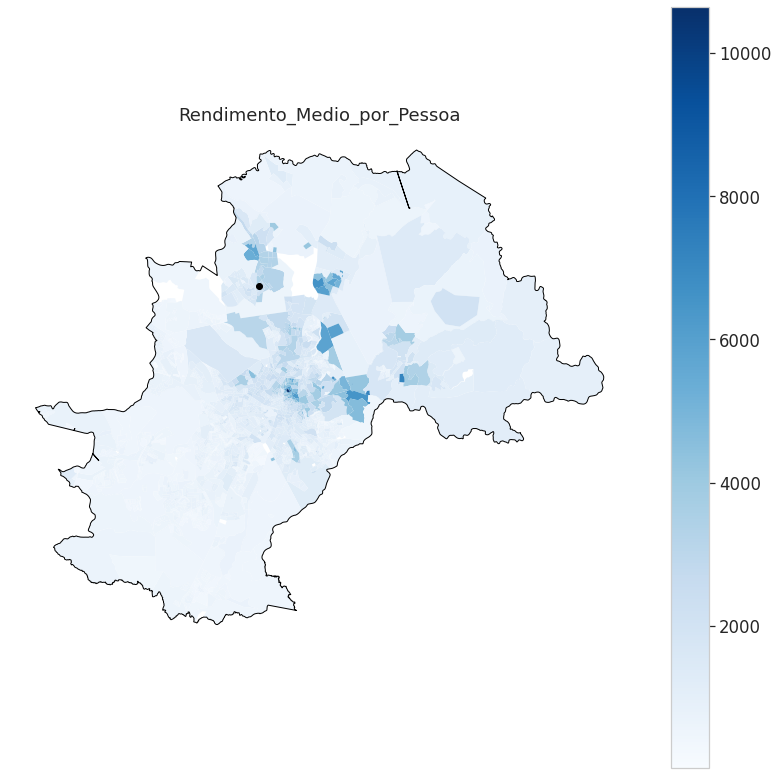

In [7]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"), sns.plotting_context('notebook', font_scale = 1.5):
    fig, ax = plt.subplots(1, 1, figsize = (14, 14))

    col = 'Rendimento_Medio_por_Pessoa'
    gdf_plot.plot(ax = ax, column = col, 
                  cmap = 'Blues',
                  lw = 0, 
                  legend = True)
    ax.set_title(col)

    #Contornos
    #gdf_malha_plot['geometry'].boundary.plot(ax = ax, color = 'grey', lw = 0.5)
    gdf_malha_plot.dissolve()['geometry'].exterior.plot(ax = ax, color = 'black', lw = 1)
        
    #Remoção de Grades e Eixos
    ax.grid(False)
    frame = plt.gca()
    frame.axes.xaxis.set_ticklabels([])
    frame.axes.yaxis.set_ticklabels([])

    #Onde Estou
    ax.scatter(x = [-47.077066751046786], y = [-22.824513385876685], color = 'black')

    #Limites de Barão Geraldo
    #ax.set_xlim([-47.08825692480783, -47.054954620383754])
    #ax.set_ylim([-22.833759042476835, -22.80021458714888])

    plt.box(False)
    plt.show()

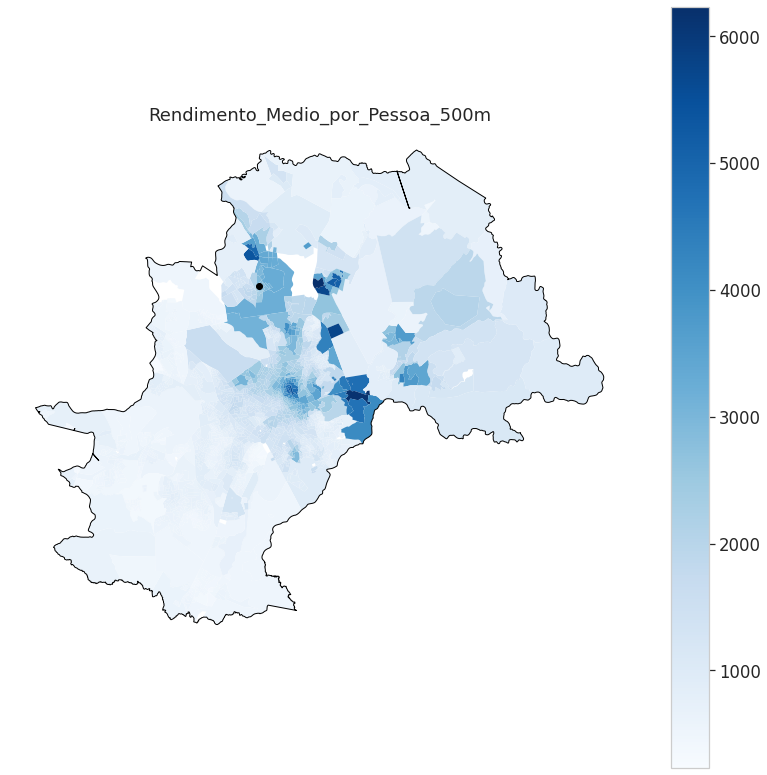

In [8]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"), sns.plotting_context('notebook', font_scale = 1.5):
    fig, ax = plt.subplots(1, 1, figsize = (14, 14))

    col = 'Rendimento_Medio_por_Pessoa_500m'
    gdf_plot.plot(ax = ax, column = col, 
                  cmap = 'Blues',
                  lw = 0, 
                  legend = True)
    ax.set_title(col)

    #Contornos
    #gdf_malha_plot['geometry'].boundary.plot(ax = ax, color = 'grey', lw = 0.5)
    gdf_malha_plot.dissolve()['geometry'].exterior.plot(ax = ax, color = 'black', lw = 1)
        
    #Remoção de Grades e Eixos
    ax.grid(False)
    frame = plt.gca()
    frame.axes.xaxis.set_ticklabels([])
    frame.axes.yaxis.set_ticklabels([])

    #Onde Estou
    ax.scatter(x = [-47.077066751046786], y = [-22.824513385876685], color = 'black')

    #Limites de Barão Geraldo
    #ax.set_xlim([-47.08825692480783, -47.054954620383754])
    #ax.set_ylim([-22.833759042476835, -22.80021458714888])

    plt.box(False)
    plt.show()

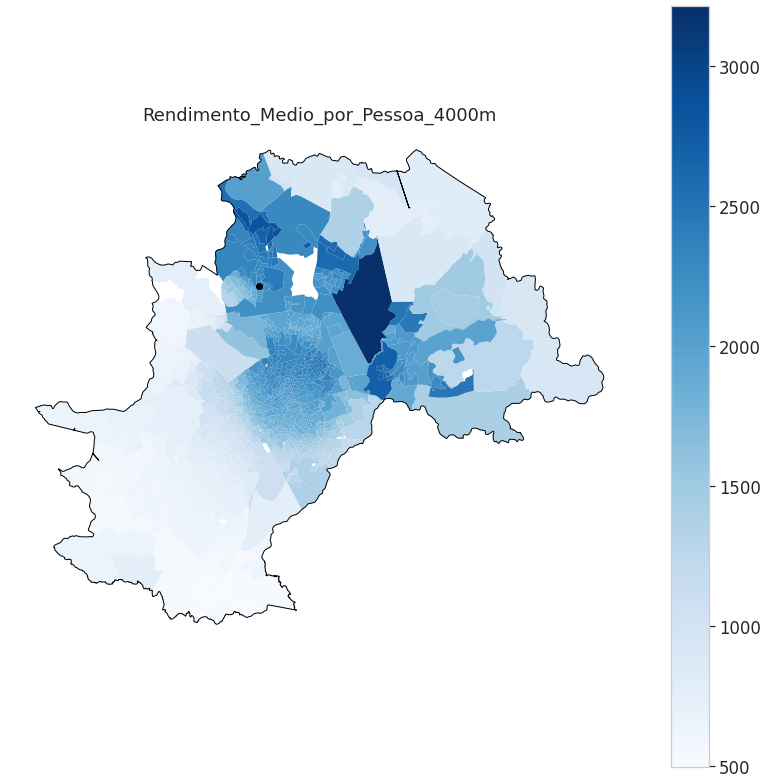

In [9]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"), sns.plotting_context('notebook', font_scale = 1.5):
    fig, ax = plt.subplots(1, 1, figsize = (14, 14))

    col = 'Rendimento_Medio_por_Pessoa_4000m'
    gdf_plot.plot(ax = ax, column = col, 
                  cmap = 'Blues',
                  lw = 0, 
                  legend = True)
    ax.set_title(col)

    #Contornos
    #gdf_malha_plot['geometry'].boundary.plot(ax = ax, color = 'grey', lw = 0.5)
    gdf_malha_plot.dissolve()['geometry'].exterior.plot(ax = ax, color = 'black', lw = 1)
        
    #Remoção de Grades e Eixos
    ax.grid(False)
    frame = plt.gca()
    frame.axes.xaxis.set_ticklabels([])
    frame.axes.yaxis.set_ticklabels([])

    #Onde Estou
    ax.scatter(x = [-47.077066751046786], y = [-22.824513385876685], color = 'black')

    #Limites de Barão Geraldo
    #ax.set_xlim([-47.08825692480783, -47.054954620383754])
    #ax.set_ylim([-22.833759042476835, -22.80021458714888])

    plt.box(False)
    plt.show()

In [15]:
lista_features = list(gdf_plot.columns[14:])

In [18]:
matriz_corr = gdf_plot[lista_features].corr()

In [25]:
pd.DataFrame(matriz_corr['Rendimento_Medio_por_Pessoa'].sort_values()).style

,Rendimento_Medio_por_Pessoa
Perc_Pardos_500m,-0.666451
Perc_Pardos,-0.660964
Perc_Negros_500m,-0.654928
Perc_Pardos_1000m,-0.646213
Perc_Negros_1000m,-0.645775
Perc_Negros_2000m,-0.621443
Perc_Pardos_2000m,-0.600242
Perc_Negros,-0.574477
Perc_Negros_4000m,-0.566589
Perc_Jovens_2000m,-0.563152


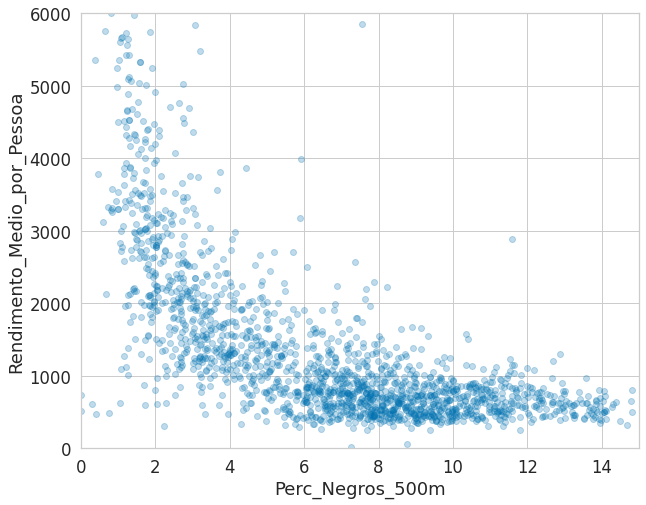

In [34]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"), sns.plotting_context('notebook', font_scale = 1.5):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))

    x_col = 'Perc_Negros_500m'
    y_col = 'Rendimento_Medio_por_Pessoa'
    ax.scatter(gdf_plot[x_col], gdf_plot[y_col], color = paleta_cores[0], alpha = 0.25)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    ax.set_xlim(0, 15)
    ax.set_ylim(0, 6000)

    plt.show()